## Read Data

In [267]:
import pandas as pd
 
#this assumes one json item per line in json file
df=pd.read_json("../data/news_category_dataset.json", lines=True)

In [268]:
df.dtypes

authors                      object
category                     object
date                 datetime64[ns]
headline                     object
link                         object
short_description            object
dtype: object

In [269]:
#number of rows (datapoints)
len(df)

124989

## Date range
Articles are between July 2014 and July 2018

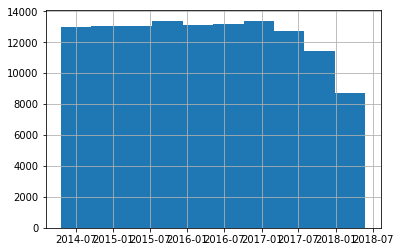

In [270]:
df.date.hist()

## Category Distribution

### Number of categories

In [271]:
len(set(df['category'].values))

31

### Category by count

Most of the articles are related to politics. Education related articles have the lowest volume.

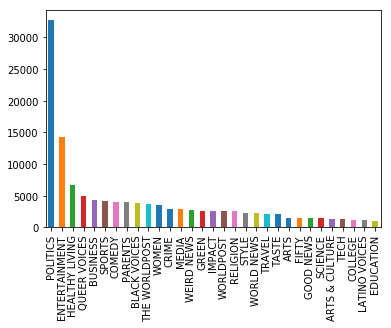

In [272]:
df['category'].value_counts().plot(kind='bar')

## Texts for Classification

These are some of the fields we can use for the classification task. We create 3 different versions.

In [276]:
import re

def tokenize_url(url:str):   
    url=url.replace("https://www.huffingtonpost.com/entry/","")
    url=re.sub("(\W|_)+"," ",url)
    return url

df['tokenized_url']=df['link'].apply(lambda x:tokenize_url(x))

#just the description
df['text_desc'] = df['short_description']

#description + headline
df['text_desc_headline'] = df['short_description'] + ' '+ df['headline']

#description + headline + tokenized url
df['text_desc_headline_url'] = df['short_description'] + ' '+ df['headline']+" " + df['tokenized_url']


In [439]:
def _reciprocal_rank(true_labels: list, machine_preds: list):
    """Compute the reciprocal rank at cutoff k"""
    
    # add index to list only if machine predicted label exists in true labels
    tp_pos_list = [(idx + 1) for idx, r in enumerate(machine_preds) if r in true_labels]

    rr = 0
    if len(tp_pos_list) > 0:
        # for RR we need position of first correct item
        first_pos_list = tp_pos_list[0]
        
        # rr = 1/rank
        rr = 1 / float(first_pos_list)

    return rr

def compute_mrr_at_k(items:list):
    """Compute the MRR (average RR) at cutoff k"""
    rr_total = 0
    
    for item in items:   
        rr_at_k = _reciprocal_rank(item[0],item[1])
        rr_total = rr_total + rr_at_k
        mrr = rr_total / 1/float(len(items))

    return mrr

def collect_preds(Y_test,Y_preds):
    """Collect all predictions and ground truth"""
    
    pred_gold_list=[[[Y_test[idx]],pred] for idx,pred in enumerate(Y_preds)]
    return pred_gold_list
             
def compute_accuracy(eval_items:list):
    correct=0
    total=0
    
    for item in eval_items:
        true_pred=item[0]
        machine_pred=set(item[1])
        
        for cat in true_pred:
            if cat in machine_pred:
                correct+=1
                break
    
    
    accuracy=correct/float(len(eval_items))
    return accuracy


In [421]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

import numpy as np
import logging

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

def extract_features(df,field,training_data,testing_data,type="binary"):
    """Extract features using different methods"""
    
    logging.info("Extracting features and creating vocabulary...")
    
    if "binary" in type:
        
        # BINARY FEATURE REPRESENTATION
        cv= CountVectorizer(binary=True, max_df=0.85,min_df=2, stop_words = 'english')
        cv.fit_transform(training_data[field].values)
        
        train_feature_set=cv.transform(training_data[field].values)
        test_feature_set=cv.transform(testing_data[field].values)
        
        return train_feature_set,test_feature_set,cv
  
    elif "counts" in type:
        
        # COUNT BASED FEATURE REPRESENTATION
        cv= CountVectorizer(binary=False, max_df=0.85,min_df=2, stop_words = 'english')
        cv.fit_transform(training_data[field].values)
        
        train_feature_set=cv.transform(training_data[field].values)
        test_feature_set=cv.transform(testing_data[field].values)
        
        return train_feature_set,test_feature_set,cv
    
    else:    
        
        # TF-IDF BASED FEATURE REPRESENTATION
        tfidf_vectorizer=TfidfVectorizer(use_idf=True,max_df=0.85,min_df=2,stop_words = 'english')
        tfidf_vectorizer.fit_transform(training_data[field].values)
        
        train_feature_set=tfidf_vectorizer.transform(training_data[field].values)
        test_feature_set=tfidf_vectorizer.transform(testing_data[field].values)
        
        return train_feature_set,test_feature_set,tfidf_vectorizer

def get_top_k_predictions(model,X_test,k):
    
    # get probabilities instead of predicted labels, since we want to collect top 3
    probs = model.predict_proba(X_test)

    # GET TOP K PREDICTIONS BY PROB - note these are just index
    best_n = np.argsort(probs, axis=1)[:,-k:]
    
    # GET CATEGORY OF PREDICTIONS
    preds=[[model.classes_[predicted_cat] for predicted_cat in prediction] for prediction in best_n]
    
    preds=[ item[::-1] for item in preds]
    
    return preds
   
    
def train_model(df,field="text_desc",feature_rep="binary",top_k=3):
    
    logging.info("Starting model training...")
    
    # GET A TRAIN TEST SPLIT (set seed for consistent results)
    training_data, testing_data = train_test_split(df,random_state = 2000,)

    # GET LABELS
    Y_train=training_data['category'].values
    Y_test=testing_data['category'].values
     
    # GET FEATURES
    X_train,X_test,feature_transformer=extract_features(df,field,training_data,testing_data,type=feature_rep)

    # INIT LOGISTIC REGRESSION CLASSIFIER
    logging.info("Training a Logistic Regression Model...")
    scikit_log_reg = LogisticRegression(verbose=1, solver='liblinear',random_state=0, C=5, penalty='l2',max_iter=1000)
    model=scikit_log_reg.fit(X_train,Y_train)

    # GET TOP K PREDICTIONS
    preds=get_top_k_predictions(model,X_test,top_k)
    
    # GET PREDICTED VALUES AND GROUND TRUTH INTO A LIST OF LISTS - for ease of evaluation
    eval_items=collect_preds(Y_test,preds)
    
    # GET EVALUATION NUMBERS ON TEST SET -- HOW DID WE DO?
    logging.info("Starting evaluation...")
    accuracy=compute_accuracy(eval_items)
    mrr_at_k=compute_mrr_at_k(eval_items)
    
    logging.info("Done training and evaluation.")
    
    return model,feature_transformer,accuracy,mrr_at_k


## Train a Single Model

### Model  - 1  (binary features with description only)

In [437]:
field='text_desc'
feature_rep='binary'
top_k=3

model,transformer,accuracy,mrr_at_k=train_model(df,field=field,feature_rep=feature_rep,top_k=top_k)
print("\nAccuracy={0}; MRR={1}".format(accuracy,mrr_at_k))

2019-07-20 14:47:38,562 : INFO : Starting model training...
2019-07-20 14:47:38,627 : INFO : Extracting features and creating vocabulary...
2019-07-20 14:47:41,300 : INFO : Training a Logistic Regression Model...


[LibLinear]

2019-07-20 14:48:59,028 : INFO : Starting evaluation...
2019-07-20 14:48:59,102 : INFO : Done training and evaluation.



Accuracy=0.5917818740399385; MRR=0.4757904505888528


### Model - 2 (tfidf features with description only)

In [438]:
field='text_desc'
feature_rep='tfidf'
top_k=3

model,transformer,accuracy,mrr_at_k=train_model(df,field=field,feature_rep=feature_rep,top_k=top_k)
print("\nAccuracy={0}; MRR={1}".format(accuracy,mrr_at_k))

2019-07-20 14:48:59,152 : INFO : Starting model training...
2019-07-20 14:48:59,218 : INFO : Extracting features and creating vocabulary...
2019-07-20 14:49:01,930 : INFO : Training a Logistic Regression Model...


[LibLinear]

2019-07-20 14:49:31,405 : INFO : Starting evaluation...
2019-07-20 14:49:31,478 : INFO : Done training and evaluation.



Accuracy=0.6224398361495136; MRR=0.504160266257057


### Model - 3 (tfidf features with description, headline, url)

In [431]:
field='text_desc_headline_url'
feature_rep='tfidf'
top_k=3

model,transformer,accuracy,mrr_at_k=train_model(df,field=field,feature_rep=feature_rep,top_k=top_k)
print("\nAccuracy={0}; MRR={1}".format(accuracy,mrr_at_k))

2019-07-20 14:43:27,098 : INFO : Starting model training...
2019-07-20 14:43:28,177 : INFO : Extracting features and creating vocabulary...
2019-07-20 14:43:34,382 : INFO : Training a Logistic Regression Model...


[LibLinear]

2019-07-20 14:44:21,831 : INFO : Starting evaluation...
2019-07-20 14:44:21,901 : INFO : Done training and evaluation.



Accuracy=0.8619431643625192; MRR=0.7447676651305563


## Check Predictions on Unseen Articles from CNN (not HuffPost our training data)

In [432]:
# https://www.cnn.com/2019/07/19/politics/george-nader-child-porn-sex-charges/index.html
test_features=transformer.transform(["George Aref Nader, who was a key witness in special counsel Robert Mueller's Russia investigation, faces new charges of transporting a minor with intent to engage in criminal sexual activity and child pornography"])
get_top_k_predictions(model,test_features,2)

[['POLITICS', 'CRIME']]

In [433]:
# https://www.cnn.com/2019/07/18/entertainment/khloe-kardashian-true-thompson-video-trnd/index.html
test_features=transformer.transform(["True Thompson makes an adorable cameo in Khloe Kardashian's new makeup tutorial video"])
model.predict(test_features)
get_top_k_predictions(model,test_features,2)

[['ENTERTAINMENT', 'STYLE']]

In [434]:
# https://www.cnn.com/2019/07/12/entertainment/heidi-klum-tom-kaulitz/
test_features=transformer.transform(["Heidi Klum is apparently the latest celeb to get married and not tell us"])
get_top_k_predictions(model,test_features,2)

[['ENTERTAINMENT', 'STYLE']]

In [435]:
# https://www.cnn.com/2019/07/19/investing/dow-stock-market-today/index.html
test_features=transformer.transform(["Stocks end lower as geopolitical fears rise. The Dow and US markets closed lower on Friday, as geopolitical worries overshadowed the hopes of interest rate cuts by the Federal Reserve."])
get_top_k_predictions(model,test_features,2)

[['BUSINESS', 'POLITICS']]

In [436]:
# https://www.cnn.com/2019/07/19/health/astronaut-exercise-iv-faint-scn/index.html
test_features=transformer.transform(["Exercise in space keeps astronauts from fainting when they return to Earth, study says"])
get_top_k_predictions(model,test_features,2)

[['SCIENCE', 'WEIRD NEWS']]

## Train Different Types of Models

In [425]:
feature_reps=['binary','counts','tfidf']
fields=['text_desc','text_desc_headline','text_desc_headline_url']
top_ks=[3]

results=[]
for field in fields:
    for feature_rep in feature_reps:
        for top_k in top_ks:
            model,transformer,acc,mrr_at_k=train_model(df,field=field,feature_rep=feature_rep,top_k=top_k)
            results.append([field,feature_rep,top_k,acc,mrr_at_k])

2019-07-20 10:20:51,853 : INFO : Starting model training...
2019-07-20 10:20:52,829 : INFO : Extracting features and creating vocabulary...
2019-07-20 10:20:55,639 : INFO : Training a Logistic Regression Model...


[LibLinear]

2019-07-20 10:22:14,881 : INFO : Starting evaluation...
2019-07-20 10:22:14,943 : INFO : Done training and evaluation.
2019-07-20 10:22:15,002 : INFO : Starting model training...
2019-07-20 10:22:15,060 : INFO : Extracting features and creating vocabulary...
2019-07-20 10:22:17,955 : INFO : Training a Logistic Regression Model...


[LibLinear]

2019-07-20 10:23:46,458 : INFO : Starting evaluation...
2019-07-20 10:23:46,543 : INFO : Done training and evaluation.
2019-07-20 10:23:46,576 : INFO : Starting model training...
2019-07-20 10:23:46,637 : INFO : Extracting features and creating vocabulary...
2019-07-20 10:23:49,253 : INFO : Training a Logistic Regression Model...


[LibLinear]

2019-07-20 10:24:18,597 : INFO : Starting evaluation...
2019-07-20 10:24:18,666 : INFO : Done training and evaluation.
2019-07-20 10:24:18,699 : INFO : Starting model training...
2019-07-20 10:24:18,754 : INFO : Extracting features and creating vocabulary...
2019-07-20 10:24:22,883 : INFO : Training a Logistic Regression Model...


[LibLinear]

2019-07-20 10:26:09,037 : INFO : Starting evaluation...
2019-07-20 10:26:09,114 : INFO : Done training and evaluation.
2019-07-20 10:26:09,152 : INFO : Starting model training...
2019-07-20 10:26:09,207 : INFO : Extracting features and creating vocabulary...
2019-07-20 10:26:13,519 : INFO : Training a Logistic Regression Model...


[LibLinear]

2019-07-20 10:28:27,871 : INFO : Starting evaluation...
2019-07-20 10:28:27,949 : INFO : Done training and evaluation.
2019-07-20 10:28:27,987 : INFO : Starting model training...
2019-07-20 10:28:28,053 : INFO : Extracting features and creating vocabulary...
2019-07-20 10:28:32,451 : INFO : Training a Logistic Regression Model...


[LibLinear]

2019-07-20 10:29:15,018 : INFO : Starting evaluation...
2019-07-20 10:29:15,098 : INFO : Done training and evaluation.
2019-07-20 10:29:15,130 : INFO : Starting model training...
2019-07-20 10:29:15,181 : INFO : Extracting features and creating vocabulary...
2019-07-20 10:29:21,013 : INFO : Training a Logistic Regression Model...


[LibLinear]

2019-07-20 10:31:23,365 : INFO : Starting evaluation...
2019-07-20 10:31:23,446 : INFO : Done training and evaluation.
2019-07-20 10:31:23,483 : INFO : Starting model training...
2019-07-20 10:31:23,546 : INFO : Extracting features and creating vocabulary...
2019-07-20 10:31:29,844 : INFO : Training a Logistic Regression Model...


[LibLinear]

2019-07-20 10:34:04,521 : INFO : Starting evaluation...
2019-07-20 10:34:04,612 : INFO : Done training and evaluation.
2019-07-20 10:34:04,656 : INFO : Starting model training...
2019-07-20 10:34:04,722 : INFO : Extracting features and creating vocabulary...
2019-07-20 10:34:10,509 : INFO : Training a Logistic Regression Model...


[LibLinear]

2019-07-20 10:34:57,064 : INFO : Starting evaluation...
2019-07-20 10:34:57,141 : INFO : Done training and evaluation.


### Results of Various Models

In [430]:
df_results=pd.DataFrame(results,columns=['text_fields','feature_representation','top_k','accuracy','mrr_at_k'])
df_results.sort_values(by=['text_fields','accuracy'],ascending=False)

,text_fields,feature_representation,top_k,accuracy,mrr_at_k
8,text_desc_headline_url,tfidf,3,0.861943,0.744768
6,text_desc_headline_url,binary,3,0.816244,0.700215
7,text_desc_headline_url,counts,3,0.815092,0.701725
5,text_desc_headline,tfidf,3,0.831733,0.711774
3,text_desc_headline,binary,3,0.789331,0.673243
4,text_desc_headline,counts,3,0.786770,0.672326
2,text_desc,tfidf,3,0.622440,0.504160
0,text_desc,binary,3,0.591782,0.475790
1,text_desc,counts,3,0.588646,0.474345
